<a href="https://colab.research.google.com/github/HOWARD258ym/HOWARD258ym/blob/main/%E3%80%8CTransfer_Learning_in_CNN_PyTorch_Class_gender_classification_example_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial step:** 

download the gender classification images from the following link:

https://tinyurl.com/yxpyltdv

Before using DCGAN to generate male and female images, the statistics is as follows:

train/male: 1000 imgs

train/female: 1000 imgs

val/male: 200 imgs

val/famale: 200 imgs

mount data to this ipynb!

@inproceedings{liu2015faceattributes,
  title = {Deep Learning Face Attributes in the Wild},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},
  month = {December},
  year = {2015} 
}

# Import dependencies

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# mount Google drive correctly
!ls /content/drive/MyDrive/TIBAME/male_female_images_mixed
%cd "/content/drive/MyDrive/TIBAME/male_female_images_mixed/"

!ls

train  val
/content/drive/MyDrive/TIBAME/male_female_images_mixed
train  val


In [37]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.hub import load_state_dict_from_url
print("torch version:",torch.__version__)

from torch.optim import lr_scheduler

import numpy as np

import torchvision
from torchvision import datasets, models, transforms
print("torchvision version:", torchvision.__version__)

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
# set Scale interval
%matplotlib inline
#plt.show() # with %matplotlib inline, no need for plt.show()

import time
import os
import copy
import cv2

import numpy as np

from PIL import Image

from google.colab.patches import cv2_imshow

plt.ion()   # interactive mode

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [38]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

#Create PyTorch data generators

In [39]:
## try to adjust data augmentation strategy 

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # adjust (size , scale , ratio) >>> here set size(224,224) pixel, scale(length & width) randomly from (0.8 ~ 1)
        transforms.RandomHorizontalFlip(p=0.7), # p : prob.
        transforms.RandomVerticalFlip(p=0.7),
        transforms.ToTensor(), # adjust grayscale range to (0-1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # adjust grayscale range in control [mean],[std] 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # CenterCrop( size=(200,200) ) reserve (200,200)pixels from center   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the directory of your data in Google Drive
# do remind that before executing DCGAN male/female face generation example, there are only 1000 images in the train/male and train/female, respectively.
# '/content/drive/My Drive/male_female_images_mixed/train/female’
# '/content/drive/My Drive/male_female_images_mixed/train/male’
data_dir = '/content/drive/MyDrive/TIBAME/male_female_images_mixed/'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [40]:
#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

show some training data. Make sure the lables match the images

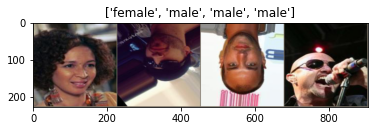

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    # if opencv is desired
    #new_img_rgb = cv2.cvtColor(np.uint8(inp*256), cv2.COLOR_BGR2RGB)
    #print(title)    
    #cv2_imshow(new_img_rgb)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Train the model

Training the model,including:

Scheduling learning rate,LR scheduler,

Saving the best model

In [42]:
NUM=14
num_epochs=NUM
epoch_train_loss_his = np.zeros(num_epochs)
epoch_val_loss_his = np.zeros(num_epochs)
epoch_train_acc_his = np.zeros(num_epochs)
epoch_val_acc_his = np.zeros(num_epochs)

#def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM):
# for resnet50
def train_model(model, criterion, optimizer, num_epochs=NUM):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)                            
                running_corrects += torch.sum(preds == labels.data)
            # ---------------------------------------------------------------
            # cal. epoch_loss & epoch_acc 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print( phase )
            # list the 'train' & 'val' loss & acc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # save my his. record 
            #for phase in ['train', 'val']:
            if phase == 'train':                
              epoch_train_loss_his[epoch] = epoch_loss
              epoch_train_acc_his[epoch] = epoch_acc
              print('CHECK if train:',phase)
            else:
              epoch_val_loss_his[epoch] = epoch_loss
              epoch_val_acc_his[epoch] = epoch_acc
              print('CHECK if val:',phase)

        print()
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
    

In [43]:
# check if anything's wrong above
#input("Please press the Enter key to proceed")
#check shape of epoch_train_loss_his & epoch_val_loss_his & epoch_train_acc_his & epoch_val_acc_his
#print(epoch_train_loss_his)

# Create the network

**Case 1:
using ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. 
Set requires_grad == False to freeze the parameters 
so that the gradients are not computed in backward().**

#CASE 1 : USE **alexnet**

In [44]:
'''
# do "feature extractor" , using ( pretrained alexnet )

model_conv = models.alexnet(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False # param.requires_grad = False ------ represent conv. no operate !!
# Parameters of newly constructed modules have requires_grad=True by default

model_conv.classifier = nn.Sequential(*[model_conv.classifier[i] for i in range(6)]) # remove the last layer i = 7 (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_conv.classifier = nn.Sequential(model_conv.classifier,addition_fc)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

# train the model with feature extractor way
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=NUM)
'''


'\n# do "feature extractor" , using ( pretrained alexnet )\n\nmodel_conv = models.alexnet(pretrained=True)\n\nfor param in model_conv.parameters():\n    param.requires_grad = False # param.requires_grad = False ------ represent conv. no operate !!\n# Parameters of newly constructed modules have requires_grad=True by default\n\nmodel_conv.classifier = nn.Sequential(*[model_conv.classifier[i] for i in range(6)]) # remove the last layer i = 7 (4096x1000)\naddition_fc = nn.Linear(4096, 2) # the layer to be stacked\nmodel_conv.classifier = nn.Sequential(model_conv.classifier,addition_fc)\n\nmodel_conv = model_conv.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that only parameters of final layer are being optimized as\n# opposed to before.\noptimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 5 epochs\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)\n\n# train the model with feature ex

#CASE 1 : USE **ResNet50**

In [45]:
# do "feature extractor" , using ( pretrained ResNet50 )
'''
### resnet50 MODEL %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
model_conv = models.resnet50(pretrained=True).to(device)

for param in model_conv.parameters():
    param.requires_grad = False # param.requires_grad = False ------ represent conv. no operate !!
# Parameters of newly constructed modules have requires_grad=True by default

print(model_conv)

# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)
model_conv.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

#(fc): Sequential(
#    (0): Linear(in_features=2048, out_features=128, bias=True)
#    (1): ReLU(inplace=True)
#    (2): Linear(in_features=128, out_features=2, bias=True)  

print(model_conv)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters())

model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=NUM)
'''

'\n### resnet50 MODEL %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\nmodel_conv = models.resnet50(pretrained=True).to(device)\n\nfor param in model_conv.parameters():\n    param.requires_grad = False # param.requires_grad = False ------ represent conv. no operate !!\n# Parameters of newly constructed modules have requires_grad=True by default\n\nprint(model_conv)\n\n# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)\nmodel_conv.fc = nn.Sequential(\n               nn.Linear(2048, 128),\n               nn.ReLU(inplace=True),\n               nn.Linear(128, 2)).to(device)\n\n#(fc): Sequential(\n#    (0): Linear(in_features=2048, out_features=128, bias=True)\n#    (1): ReLU(inplace=True)\n#    (2): Linear(in_features=128, out_features=2, bias=True)  \n\nprint(model_conv)\n\ncriterion = nn.CrossEntropyLoss()\noptimizer_conv = optim.Adam(model_conv.fc.parameters())\n\nmodel_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=NUM)\n'

# **Case 2:**
Finetuning the convnet, Load a pretrained model and reset final fully connected layer.**

#CASE 2 : USE **alexnet**

In [ ]:
'''
## Alexnet
 
# change models.alexnet(pretrained=false) >>> use default() ------ train Alexnet from scratch!!
model_ft = models.alexnet(pretrained=True).to(device)

model_ft.classifier = nn.Sequential(*[model_ft.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)
#model_ft = nn.Sequential(model_ft,addition_fc)

criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train the model using a fined-tuned way
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM)
'''

#CASE 2 : USE **ResNet50**

In [46]:
'''
# do "Finetuning " , using ( pretrained ResNet50 )

### resnet50 MODEL %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
model_conv = models.resnet50(pretrained=True).to(device)

# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)
model_conv.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device) 

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters())

model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=NUM)
'''

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/13
----------
train
train Loss: 0.4943 Acc: 0.7540
CHECK if train: train
val
val Loss: 0.2768 Acc: 0.8850
CHECK if val: val

Epoch 1/13
----------
train
train Loss: 0.4433 Acc: 0.8025
CHECK if train: train
val
val Loss: 0.2796 Acc: 0.8850
CHECK if val: val

Epoch 2/13
----------
train
train Loss: 0.4263 Acc: 0.8015
CHECK if train: train
val
val Loss: 0.2133 Acc: 0.9275
CHECK if val: val

Epoch 3/13
----------
train
train Loss: 0.4105 Acc: 0.8080
CHECK if train: train
val
val Loss: 0.2206 Acc: 0.9175
CHECK if val: val

Epoch 4/13
----------
train
train Loss: 0.4122 Acc: 0.8025
CHECK if train: train
val
val Loss: 0.2032 Acc: 0.9325
CHECK if val: val

Epoch 5/13
----------
train
train Loss: 0.4310 Acc: 0.8055
CHECK if train: train
val
val Loss: 0.2272 Acc: 0.9050
CHECK if val: val

Epoch 6/13
----------
train
train Loss: 0.3689 Acc: 0.8445
CHECK if train: train
val
val Loss: 0.2041 Acc: 0.9200
CHECK if val: val

Epoch 7/13
----------
train
train Loss: 0.3612 Acc: 0.8395
CHECK if t

#**Case 3:**
Load a non-pretrained model and reset final fully connected layer ** 

#CASE 3 : USE **alexnet**

In [47]:
'''
## Alexnet
# change ResNet50
 
#model_ft = models.alexnet(pretrained=True) # model_ft : finetune model
# change models.alexnet(pretrained=false) >>> use default() ------ train Alexnet from scratch!!
model_ft = models.alexnet()
model_ft.classifier = nn.Sequential(*[model_ft.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)
#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_ft)
##

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train the model using a fined-tuned way
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM)
'''

'\n## Alexnet\n# change ResNet50\n \n#model_ft = models.alexnet(pretrained=True) # model_ft : finetune model\n# change models.alexnet(pretrained=false) >>> use default() ------ train Alexnet from scratch!!\nmodel_ft = models.alexnet()\nmodel_ft.classifier = nn.Sequential(*[model_ft.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)\naddition_fc = nn.Linear(4096, 2) # the layer to be stacked\nmodel_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)\n#model_ft = nn.Sequential(model_ft,addition_fc)\nprint(model_ft)\n##\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n#criterion = FocalLoss()\n\n# Observe that all parameters are being optimized\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)\n\n# step size could be\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)\n\n# train the model using a fined-tuned way\nmodel_ft = train_model(model_ft, criterion, optimizer_ft,

#CASE 3 : USE **ResNet50**

In [48]:
'''
## do "train resnet50 from scratch!!" , using ( ResNet50 )
 
model_conv = models.resnet50().to(device)
# change models.resnet50(pretrained=false) >>> use default() ------ train resnet50 from scratch!!

# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)
model_conv.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device) 

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters())

model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=NUM)
'''

Epoch 0/13
----------
train
train Loss: 0.6979 Acc: 0.5430
CHECK if train: train
val
val Loss: 0.6788 Acc: 0.5850
CHECK if val: val

Epoch 1/13
----------
train
train Loss: 0.6898 Acc: 0.5380
CHECK if train: train
val
val Loss: 0.6846 Acc: 0.5450
CHECK if val: val

Epoch 2/13
----------
train
train Loss: 0.6920 Acc: 0.5265
CHECK if train: train
val
val Loss: 0.6941 Acc: 0.5050
CHECK if val: val

Epoch 3/13
----------
train
train Loss: 0.6959 Acc: 0.4985
CHECK if train: train
val
val Loss: 0.6920 Acc: 0.5125
CHECK if val: val

Epoch 4/13
----------
train
train Loss: 0.6936 Acc: 0.5000
CHECK if train: train
val
val Loss: 0.6920 Acc: 0.5075
CHECK if val: val

Epoch 5/13
----------
train
train Loss: 0.6933 Acc: 0.4900
CHECK if train: train
val
val Loss: 0.6922 Acc: 0.5075
CHECK if val: val

Epoch 6/13
----------
train
train Loss: 0.6933 Acc: 0.4920
CHECK if train: train
val
val Loss: 0.6916 Acc: 0.5150
CHECK if val: val

Epoch 7/13
----------
train
train Loss: 0.6933 Acc: 0.5070
CHECK if t

In [49]:
# save data 
#np.savez_compressed('savez_compressed.npz', my_arr1=epoch_train_loss_his, my_arr2=epoch_val_loss_his, my_arr3=epoch_train_acc_his, my_arr4=epoch_val_acc_his )

# load data
#npz_file = np.load('savez_compressed.npz')
#new_arr1, new_arr2, new_arr3, new_arr4  = npz_file['my_arr1'], npz_file['my_arr2'], npz_file['my_arr3'], npz_file['my_arr4']

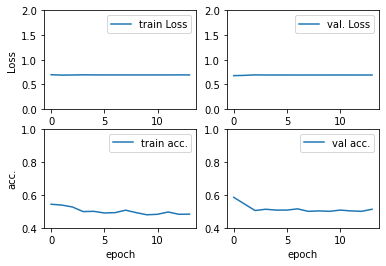

In [50]:
# print  history
# epoch_train_loss_his & epoch_val_loss_his & epoch_train_acc_his & epoch_val_acc_his

plt.figure()

x_values=list(range(num_epochs))

# fig.1
plt.subplot(2, 2, 1)
plt.plot(x_values,epoch_train_loss_his)
plt.legend(['train Loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.ylim(0,2)

# fig.2
plt.subplot(2, 2, 2)
plt.plot(x_values,epoch_val_loss_his)
plt.legend(['val. Loss'])
plt.xlabel('epoch')
#plt.ylabel('Loss')
plt.ylim(0,2)

# fig.3
plt.subplot(2, 2, 3)
plt.plot(x_values,epoch_train_acc_his)
plt.legend(['train acc.'])
plt.xlabel('epoch')
plt.ylabel('acc.')
plt.ylim(0.4,1)

# fig.4
plt.subplot(2, 2, 4)
plt.plot(x_values,epoch_val_acc_his)
plt.legend(['val acc.'])
plt.xlabel('epoch')
#plt.ylabel('acc.')
plt.ylim(0.4 ,1)

#x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
#y_major_locator=MultipleLocator(0.5)

#ax=plt.gca()
#ax为两条坐标轴的实例
#ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
#ax.yaxis.set_major_locator(y_major_locator)

# part of code modified from: https://blog.csdn.net/weixin_44520259/article/details/89917026

plt.show()

**Visualizing the model predictions:**
Generic function to display predictions for a few images

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


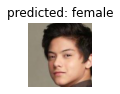

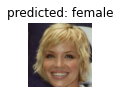

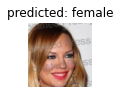

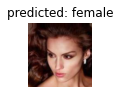

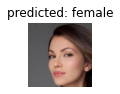

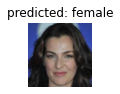

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
#visualize_model(model_ft)
visualize_model(model_conv)